# 情報活用講座：　ケモインフォマテックス 実践編　
# 第5回：　水溶解度データと構造生成


## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第９章第３節　プロジェクトの例/ 解析例２：水溶解度データと構造生成

## データセット
journal_data.csvはプロピレンの酸素酸化によるプロピレンオキシド製造用触媒に関する特許から、反応温度が200℃以上で担体がCaCO3である触媒データを収集したデータセットです[1] 。このデータセットは、船津らによる『ケモインフォマティックス手法による新規触媒候補の提案』で使用されたもので、触媒組成や反応条件とそのときの触媒性能に関する75件のデータがまとめられています。


[1] 植村 圭祐、荒川 正幹、船津 公人　"ケモインフォマティックス手法による新規触媒候補の提案", Journal of Computer Aided Chemistry Vol.7(2006) 、https://www.jstage.jst.go.jp/article/jcac/7/0/7_0_69/_pdf/-char/ja

【触媒組成】  
重量比は担体を含めた触媒全体に対する重量比であるため、100%に満たない残りの部分は担体などになります。
1. Agの重量比[wt %]
1. Kの重量比[wt %]
1. Moの重量比[wt %]
1. Wの重量比[wt %]
1. Reの重量比[wt %]
1. Auの重量比[wt %]
1. Clの重量比[wt %]
1. Mgの重量比[wt %]
1. Feの重量比[wt %]

【反応条件】
1. Temp: 温度　[℃]
1. P:  圧力　[psig]
1. GHSV: 空間速度 [hr-1]  
1. C3: 原料中のプロピレンの割合[mol %]
1. O2: 酸素の割合[mol %]
1. NOx: 窒素酸化物の割合[mol %]
1. EtCl: 塩化エチルの割合[mol %]
1. CO2: 二酸化炭素の割合[mol %]

空間速度(GHSV: gas hourly space velocity)とは原料の体積流量を触媒層体積で割ったものです。なおpsigは圧力の単位で、1 psigはSI単位系では6894.757 Paです。

【前処理の有無】  
触媒前処理は、窒素酸化物（pNOx）、塩化エチル（pEtCl）、二酸化炭素（pCO2）のそれぞれを用いて触媒の前処理を行った場合を1、前処理を行わ
なかった場合を0とした変数です。
1. pNOx：　窒素酸化物を用いた触媒の前処理の有無
1. pEtCl：　塩化エチルを用いた触媒の前処理の有無
1. pCO2：　二酸化炭素を用いた触媒の前処理の有無

【反応の結果】
1. Conv: プロピレンの転化率[%]
1. Sel:  プロピレンオキシドの選択率[%]
1. yield: 収率[%]


[1]の論文では性能の高い触媒の組成を求めるため、説明変数には触媒組成、反応条件、触媒前処理の有無を用い、転化率と選択率をそれぞれ目的変数として、説明変数と目的変数の間でPLS法による回帰分析が行われています。


## 目標

* `cheminfo/descriptors.py`に保存した記述子計算クラスを使って、SMILESから記述子計算をする。
* PLSによる回帰分析で予測性の高い記述子計算を選定する

## 1.分子構造データの読み込み 
### ライブラリのインポート

In [1]:
#データ構造化ライブラリ
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 

#機械学習のライブラリ
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics

#記述子ライブラリ
from rdkit import Chem
from rdkit.Chem.AllChem import GetHashedMorganFingerprint

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

In [2]:
df=pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [3]:
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

## ハッシュ化されたMorganフィンガープリントの例

In [4]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
hmfp = GetHashedMorganFingerprint(mol=toluene, radius=3, nBits=512)

In [5]:
hmfp.GetNonzeroElements()

{31: 2,
 33: 1,
 64: 3,
 175: 2,
 186: 1,
 214: 2,
 287: 1,
 309: 1,
 337: 5,
 356: 1,
 384: 1,
 389: 1,
 411: 1}

## ハッシュ化されたMorganフィンガープリントを出力するクラス

In [6]:
from cheminfo.descriptors import HashedMorgan

hm = HashedMorgan()
X = hm.fit_transform(df['mol'])

In [7]:
X.shape

(1128, 512)

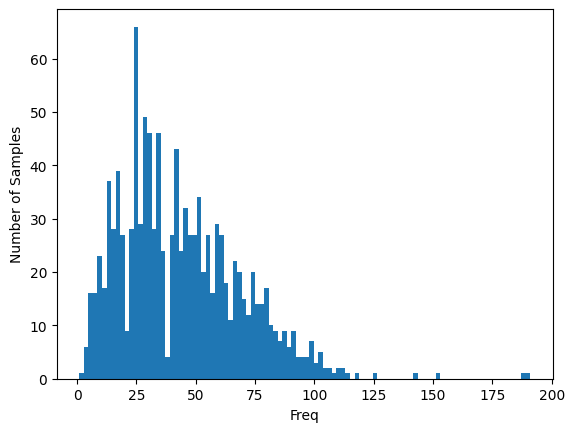

In [8]:
plt.hist(X.sum(axis=1), bins=100)

plt.xlabel('Freq')
plt.ylabel('Number of Samples')
plt.show()

## PLSと最適な記述子

In [9]:
df_train, df_test = train_test_split(df, 
                                     test_size=.20, 
                                     random_state=42)

In [10]:
TARGET=['measured log solubility in mols per litre']

In [11]:
ytrain = df_train[TARGET]
ytrain

,measured log solubility in mols per litre
876,-1.400
712,-0.390
554,-4.400
688,-2.676
780,-8.000
...,...
121,-4.800
1044,-2.120
1095,-3.620
860,-0.460


In [12]:
params={'n_components': np.arange(1,16)}
scores = np.zeros((18,3))
count = 0

for radius in range(1, 4):
    for n_bits in 2**np.arange(5, 11):
        model = GridSearchCV(PLSRegression(), params, cv=5)
        Xtrain = HashedMorgan(n_bits, radius).fit_transform(df_train['mol'])

        model.fit(Xtrain, ytrain)
        
        score_cv = model.best_score_
        scores[count,:] = np.array([radius, n_bits, score_cv])
        count+=1 

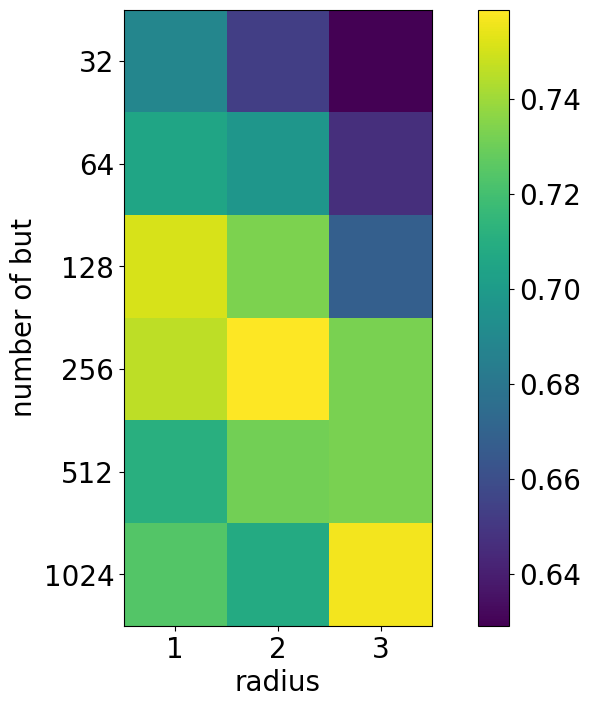

In [13]:
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['font.size'] = 20
fig,ax=plt.subplots()
im = ax.imshow(scores[:,-1].reshape(3,6).T)
fig.colorbar(im)

ax.set_xticks(range(3))
ax.set_yticks(range(6))
ax.set_xticklabels(range(1,4))
ax.set_yticklabels(map(int,scores[:6,1]))

plt.xlabel('radius')
plt.ylabel('number of but')
#plt.savefig('./results/10.3-optim-hashedmorgan-pls.jpg')
plt.show()

### 最良のパラメータを確認

In [14]:
ix=scores[:,-1].argmax()
print('radius: {}, n_bits: {} R^2:{:.3f}'.format(*scores[ix,:]))

radius: 2.0, n_bits: 256.0 R^2:0.759


## PLSとRDKit記述子の場合

In [15]:
from cheminfo.descriptors import RDKitDescriptor

rdcalc = RDKitDescriptor()

X = rdcalc.fit_transform(df_train['mol'])
Xtrain = np.array(X.tolist())

X2 = rdcalc.transform(df_test['mol'])
Xtest = np.array(X2.tolist())

In [16]:
ytest = df_test[TARGET]

In [17]:
params = {'n_components': np.arange(1, 16)}
optim = GridSearchCV(PLSRegression(), params)

In [18]:
optim.fit(Xtrain, ytrain)

GridSearchCV(estimator=PLSRegression(),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [19]:
ycalc = optim.predict(Xtrain)
ypred = optim.predict(Xtest)

In [20]:
print('calc: %.3f'%metrics.r2_score(ytrain,ycalc))
print('cv: %.3f'%optim.best_score_)
print('pred: %.3f'%metrics.r2_score(ytest,ypred))

calc: 0.921
cv: 0.884
pred: 0.892


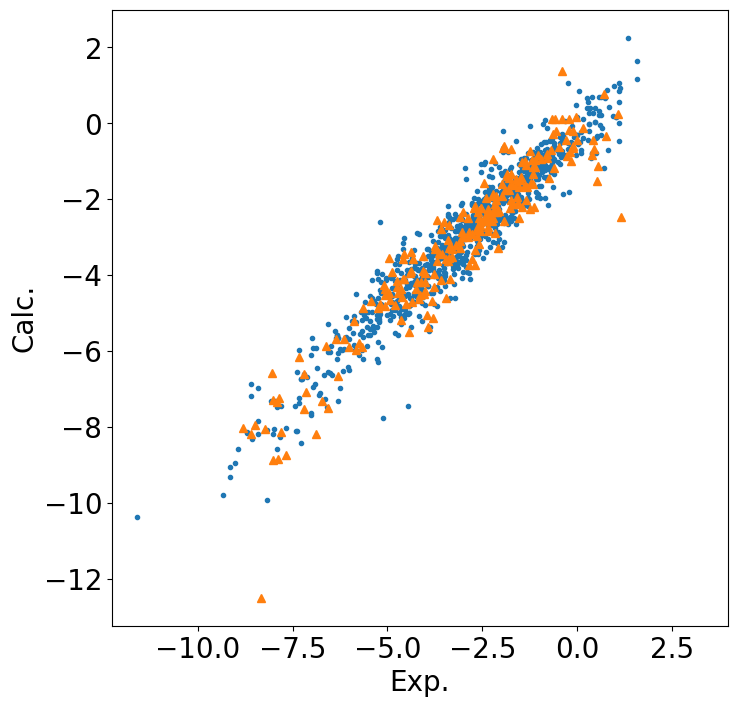

In [21]:
plt.plot(ytrain, ycalc, '.')
plt.plot(ytest, ypred, '^')
plt.plot()

plt.axis('square')
plt.xlabel('Exp.')
plt.ylabel('Calc.')
plt.savefig('./results/9.3-yyplot-rdkitpls.jpg')
plt.show()

### 交差検定の結果、良好な精度だったので利用する（モデル保存）

In [22]:
from joblib import dump
dump(optim, './models/9.3_rdkit_pls.joblib')

['./models/9.3_rdkit_pls.joblib']

### スクリーニング

In [23]:
from cheminfo.metrics import t2_score, q_value 

https://nirpyresearch.com/outliers-detection-pls-regression-nir-spectroscopy-python/

In [24]:
def t2_score2(data, model):
    "T2値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    explained_std_ = np.sqrt(model.best_estimator_.x_scores_.var(axis=0))
    scores_whiten = model.transform(data) / explained_std_
    return (scores_whiten ** 2.). sum(axis=1)

def q_value2(data, model):
    "Q値の計算モジュール"
    assert type(data)==pd.DataFrame or type(data)==np.ndarray, "input must be pandas.DataFrame or np.array"
    
    x_reproduced_ = model.transform(data) @ model.best_estimator_.x_loadings_.T
    
    return ((data - x_reproduced_)**2.).sum(axis=1)

In [25]:
t2_values = t2_score2(Xtrain, optim)
t2_values

array([  7.05995208,   4.56087579,   5.45560254,   6.84370686,
        19.88419491,  10.39480099,   4.76643972,   8.42610944,
        14.44074248,  24.89835948,  15.55204787,  12.87393385,
        47.4557283 ,   3.21586639,  17.96683474,   2.91947827,
         4.20369407, 155.5385541 ,  14.00837827,   7.3722023 ,
        15.22236775,   3.87699733,  10.31237017,   3.41472596,
         4.48743066,  10.66278217,  11.2037106 ,  12.81201724,
        12.5343981 ,  13.78923234,   5.73436743,   5.83211087,
         5.94735348,   5.49645287,  10.13241682,   6.07910307,
         6.84631589,  14.32987061,  14.52476015,  38.11087969,
         2.80198788,  23.96594688,   8.75634245,   6.54825232,
         4.24650498,   3.25434387,   5.02883907,   6.43057911,
         6.04066388,  14.08726631,   8.88531535,   4.92553454,
        16.2643829 ,   8.79706013,   7.03659992,  13.84746788,
         9.09460892,   4.05363557,  10.03255279,   9.22093879,
        17.54965935,  17.72709057,  13.70423605,   4.93

In [26]:
q_values = q_value2(Xtrain, optim)
q_values

array([9.02336728e+04, 2.10114749e+04, 5.37106024e+05, 1.67625550e+06,
       1.58232663e+10, 2.02780560e+07, 3.33411096e+07, 1.93783102e+07,
       4.45302429e+06, 7.46560216e+11, 1.06157562e+11, 4.23491739e+08,
       1.25661768e+06, 5.53549823e+04, 3.88391459e+09, 7.94116185e+04,
       3.08206395e+04, 3.74508269e+13, 1.02234555e+08, 6.27636046e+05,
       8.48817725e+06, 5.52541726e+04, 4.45049373e+04, 8.03994453e+04,
       1.56155763e+05, 3.70688710e+07, 7.50262008e+07, 7.57455265e+06,
       6.99491673e+08, 1.85018957e+10, 7.63323858e+04, 4.50373477e+06,
       4.42902538e+06, 7.35444491e+04, 1.67741329e+05, 5.50029708e+04,
       2.17230556e+07, 9.56023358e+07, 5.70953482e+12, 1.07912099e+10,
       2.78277198e+05, 1.92081055e+13, 1.98671855e+05, 2.61219579e+05,
       5.55689453e+04, 5.50691510e+04, 1.11351551e+07, 1.73665899e+05,
       7.52372538e+04, 1.18780325e+10, 2.00614626e+05, 3.01003421e+04,
       8.17363122e+04, 2.93741449e+05, 2.58816486e+05, 1.29748238e+08,
      

In [31]:
T = optim.best_estimator_.x_scores_
T.shape

(902, 12)

In [32]:
P = optim.best_estimator_

In [33]:
# Calculate error array
Err = Xtrain - np.dot(X,P.T)
Err.shape

AttributeError: 'PLSRegression' object has no attribute 'T'

In [34]:
q_values = np.sum(Err**2, axis=1)
q_values

NameError: name 'Err' is not defined

In [35]:
# Calculate Hotelling's T-squared (note that data are normalised by default)
Tsq = np.sum((T/np.std(T, axis=0))**2, axis=1)

In [36]:
Tsq

array([  7.05995208,   4.56087579,   5.45560254,   6.84370686,
        19.88419491,  10.39480099,   4.76643972,   8.42610944,
        14.44074248,  24.89835948,  15.55204787,  12.87393385,
        47.4557283 ,   3.21586639,  17.96683474,   2.91947827,
         4.20369407, 155.5385541 ,  14.00837827,   7.3722023 ,
        15.22236775,   3.87699733,  10.31237017,   3.41472596,
         4.48743066,  10.66278217,  11.2037106 ,  12.81201724,
        12.5343981 ,  13.78923234,   5.73436743,   5.83211087,
         5.94735348,   5.49645287,  10.13241682,   6.07910307,
         6.84631589,  14.32987061,  14.52476015,  38.11087969,
         2.80198788,  23.96594688,   8.75634245,   6.54825232,
         4.24650498,   3.25434387,   5.02883907,   6.43057911,
         6.04066388,  14.08726631,   8.88531535,   4.92553454,
        16.2643829 ,   8.79706013,   7.03659992,  13.84746788,
         9.09460892,   4.05363557,  10.03255279,   9.22093879,
        17.54965935,  17.72709057,  13.70423605,   4.93

In [38]:
t2_95q = np.quantile(t2_values, 0.95)
qval_95q = np.quantile(q_values, 0.95)

print('t^2 - 95% quantile', t2_95q, '\nq value - 95% quantile', qval_95q)

t^2 - 95% quantile 30.50314490262574 
q value - 95% quantile 512214874491.59174


In [42]:
count = 0 
with open('./results/mol_single.smi', 'r') as f:
    for line in f:
        line = line.strip()
        info = line.split()
        if np.float(info[2])<=t2_95q and np.float(info[3])<=qval_95q:
            count += 1
    else:
        print('予測結果の信頼できる化合物の数', count)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
plt.plot(t2_values, q_values, 'o')

plt.xlabel('$T^2$ score')
plt.ylabel('$Q$ score')
plt.vlines(t2_95q, ymin=0, ymax=q_values.max(), linestyles='--')
plt.hlines(qval_95q, xmin=0, xmax=t2_values.max(), linestyles='--')

plt.show()